# Equation discovery for Turing patterns

In [2]:
import sys
data_path = './'
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/My Drive/biophysics_summer_school_2025/data_tutorial_3/'
    sys.path.append('/content/drive/My Drive/biophysics_summer_school_2025')

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import get_basis, greedy_basis_search, evaluate_basis, get_latex_model, get_model_from_labels, add_superfluous_functions

Mounted at /content/drive


## 1. Simulating the Turing patterns in 1D

The goal of this tutorial is to extend the SFI approach to PDE models to learn the equation of Turing patterns. We will study the ASDM model in 1D, with stochastic noise (because why not)

$$\frac{\partial a}{\partial t} = d \Delta a + a^2s - a + \sqrt{2D} \xi_{a,t}, \\ \frac{\partial s}{\partial t} = \Delta s + \mu (1-a^2s) + \sqrt{2D} \xi_{s,t}.$$

Were $\mathbb{E}[\xi_{u,t}\xi_{v,s}] = \delta_{uv}\delta(t-s)$ is a Gaussian white noise. **<font color='red'>Copy paste the code of tutorial 1 to simulate the above equations in 1D and make sure they work. Simulate with $L=20.0, N=128, T=30, d=0.05, \mu=1.4$.</font>**

In [3]:
def laplacian(X, dx):
    """
    Compute the finite-difference Laplacian of a spatiotemporal field using periodic boundary conditions.

    Parameters:
        X : ndarray of shape (Nt, ..., Nx)
            Time series of spatial data (e.g. (Nt, d, N) or (Nt, d, N, N) for 1D or 2D).
        dx : float
            Grid spacing.

    Returns:
        L : ndarray of same shape as X
            Discrete Laplacian of the field.
    """
    n = len(X.shape) - 1
    L = -2*n* X

    for i in range(n):
        L += np.roll(X, 1, axis=i+1) + np.roll(X, -1, axis=i+1)

    return L/(dx ** 2)


def asdm_force(X, dx, args):
    """
    Compute the deterministic part of the ASDM dynamics:

    Parameters:
        X : ndarray of shape (Nt, 2, N)
            Activator and substrate concentrations over space and time.
        dx : float
            Grid spacing.
        args : tuple (d, mu)
            Model parameters: d (diffusion), mu (growth rate).

    Returns:
        dXdt : ndarray of shape (Nt, 2, N)
            Time derivatives of a and s.
    """
    dXdt = np.empty_like(X)

    d, mu = args
    La = laplacian(X[:,0,:], dx)
    Ls = laplacian(X[:,1,:], dx)
    a2s = X[:,1,:]*X[:,0,:]**2
    dXdt[:,0,:] = (d * La + a2s - X[:,0,:])
    dXdt[:,1,:] = (1 * Ls + mu * (1 - a2s))
    return dXdt

def simulate(X0, force_args, force_function=asdm_force, N=32, T=5000, dt=0.005, L=50, D=0.0,
             num=100):
    dx = L / (N - 1)
    """
    Simulate a spatiotemporal PDE with additive Gaussian noise using Euler-Maruyama integration.

    Parameters:
        X0 : ndarray of shape (2, N)
            Initial condition for activator and substrate.
        force_args : tuple
            Arguments for the force function.
        force_function : callable
            Function that computes the deterministic time derivative.
        N : int
            Number of spatial grid points.
        T : float
            Total simulation time.
        dt : float
            Integration time step.
        L : float
            Physical length of the domain.
        D : float
            Noise strength.
        num : int
            Store one frame every 'num' iterations.

    Returns:
        trajectory : ndarray of shape (time, 2, N) Recorded trajectory of the system.
    """
    X = X0[None,:]
    trajectory = []

    n_iter = int(T/dt)

    for i in tqdm(range(n_iter)):
        force = force_function(X, dx, force_args)
        X += dt * force + np.sqrt(2*D*dt)*np.random.normal(size=(X.shape))

        if i % num == 0:
            trajectory.append(X[0,:].copy())

    trajectory = np.array(trajectory)
    return trajectory

In [4]:
dt = 0.001
L = 20.0
N = 128
T = 30
force_args = (0.05, 1.4)
dx = L/(N-1)

np.random.seed(0)
a0 = np.ones(N) + 1e-6*np.random.rand(N)
s0 = np.ones(N) + 1e-6*np.random.rand(N)

num = 10
X = simulate(np.array([a0, s0]), force_args, N=N, T=T, D=0.001, dt=dt, L=L, num=num)

100%|██████████| 30000/30000 [00:02<00:00, 10408.05it/s]


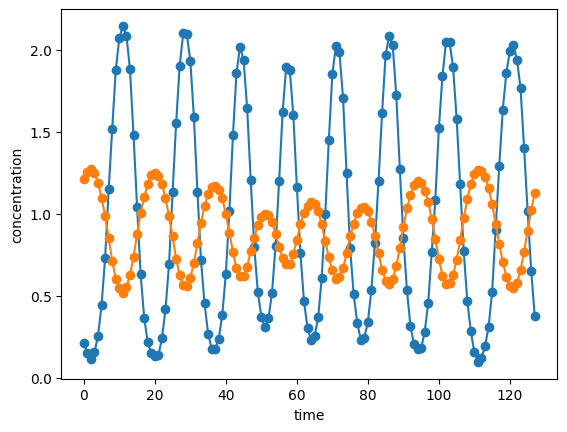

In [5]:
plt.figure()
plt.plot(X[-1,0,:], 'o-', label='activator')
plt.plot(X[-1,1,:], 'o-', label='substrate')
plt.xlabel('time')
plt.ylabel('concentration')
plt.show()

## 2. Extending the SFI approach to Stochastic Partial Differential Equation (SPDEs) learning

The routine `get_basis` has been designed to also be able to produce functions basis over fields $\mathbf{\phi}(\mathbf{x},t)$. On particular, these function can take a field, which is an array of dimension (d, Nt, N_1, ..., N_n) and compute any operator on this field. Operators like Laplacian, gradients, or mixed terms involving products of gradients and fields.

```python
basis = get_basis(field_dim=2, dx=0.1, n=1, degree=3)
```
will create a basis for a field of two dimensions (here substrate and activator concentrations); with grid spacing $dx=0.1$ for gradients and laplacians, $n=1$ space variables (here we will work in 1D), and polynomial terms of degree up to three in the field. It will also return mixed terms that could account for potential convective effects. Y


The SFI approach described in tutorial 2 can be extended in a straightforward way to SPDEs for fields $\mathbf{\phi}(\mathbf{x},t)) \in \mathbb{R}^d$ over variables $\mathbf{x}$ of dimension $n$ by only the *averaging* operator, ie we now have:

$$
\langle \cdot \rangle = \frac{1}{T L^n}\sum_{t,x} \cdot \Delta t \Delta x^n \text{ instead of } \langle \cdot \rangle = \frac{1}{T}\sum_{t,x} \cdot \Delta t
$$

The log-likelihood will also read

$$
\mathcal{L} = -\frac{T L^n}{4} \langle \left( \frac{\Delta \mathbf{x}_t}{\Delta t} - \hat{\mathbf{F}}(\mathbf{x}_t) \right)^T \hat{\mathbf{D}}^{-1} \left( \frac{\Delta \mathbf{x}_t}{\Delta t} - \hat{\mathbf{F}}(\mathbf{x}_t) \right) \rangle  \text{ instead of } \mathcal{L} = \frac{-T}{4} \langle \left( \frac{\Delta \mathbf{x}_t}{\Delta t} - \hat{\mathbf{F}}(\mathbf{x}_t) \right)^T \hat{\mathbf{D}}^{-1} \left( \frac{\Delta \mathbf{x}_t}{\Delta t} - \hat{\mathbf{F}}(\mathbf{x}_t) \right) \rangle
$$

**<font color='red'>Extend the functions implemented in correction of the tutorial to accounts for the extra dimensions and compare with a scatter plot the inferred force with the true force evaluted on the trajectory (like in tutorial 2).</font>**

In [6]:
def compute_mean_diffusion(X, args):
    """
    Estimate the diffusion matrix from a spatiotemporal trajectory using finite differences.

    Parameters:
        X : ndarray of shape (Nt, d, Nx)
            The observed trajectory.
        args : tuple (T, L)
            Total time and spatial length.

    Returns:
        Dhat : ndarray of shape (d, d)
            Estimated diffusion matrix.
    """
    T, L = args
    dt = T/X.shape[0]
    dx = L/X.shape[2]
    N = X.shape[2:]
    volume_element = dx**len(N) / L**len(N)

    dX = (X[1:] - X[:-1])
    dX_flat = np.moveaxis(dX, 0, -1).reshape((dX.shape[1], -1))
    Dhat = dX_flat@dX_flat.T * volume_element/ (2*T)
    return Dhat


def infer_force_coefficients(X, args, basis_functions):
    """
    Estimate coefficients of the force field projected onto a basis using least squares.

    Parameters:
        X : ndarray of shape (Nt, d, Nx)
            The observed trajectory.
        args : tuple (T, L)
            Total time and spatial length.
        basis_functions : dict
            Dictionary mapping LaTeX-formatted labels to basis functions.

    Returns:
        Fhat : ndarray of shape (nB,)
            Estimated coefficients for each basis function.
    """
    T, L = args
    dt = T/X.shape[0]
    dX = (X[1:] - X[:-1]) / dt


    D_hat = compute_mean_diffusion(X, args)
    D_inv = np.linalg.inv(D_hat)

    B = evaluate_basis(X[:-1], basis_functions)

    Nt, nB, d, *N = B.shape
    dx = L / (N[0] - 1)
    volume_element = dx**len(N) / L**len(N)

    # Compute Gram matrix via einsum
    Bf = np.moveaxis(B, 0, 2).reshape((nB, d, -1))
    G = np.einsum('ab,ian,jbn->ij', D_inv, Bf, Bf, optimize=True) * dt * volume_element / T
    # Compute RHS
    dXf = np.moveaxis(dX, 0, 1).reshape((d, -1))
    b = np.einsum('ac,an,jcn->j', D_inv, dXf, Bf, optimize=True) * dt * volume_element / T

    Fhat = np.linalg.solve(G, b)
    return Fhat

def reconstruct_force_field(X, coeffs, basis_functions):
    """
    Reconstruct the inferred force field using the estimated coefficients and basis.

    Parameters:
        X : ndarray of shape (Nt, d, Nx)
            Input field data.
        coeffs : ndarray of shape (nB,)
            Coefficients of the active basis functions.
        basis_functions : dict
            Dictionary of basis functions.

    Returns:
        F : ndarray of shape (Nt, d, Nx)
            Inferred force field at each space-time point.
    """
    X = np.moveaxis(X, 0, 1)
    F = np.zeros_like(X)
    for c, f in zip(coeffs, basis_functions.values()):
        F += c * f(X)
    F = np.moveaxis(F, 1, 0)
    return F

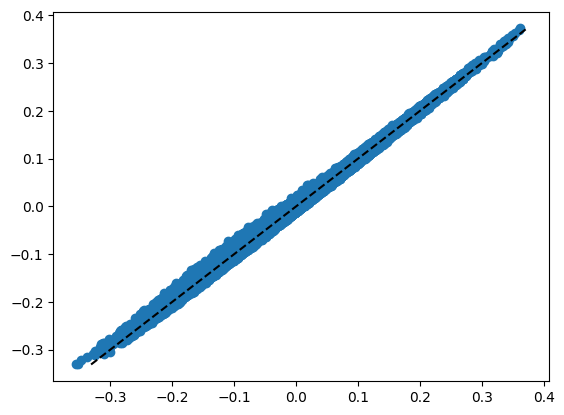

In [7]:
basis = get_basis(field_dim=2, dx=dx, n=1, degree=3)
coeffs = infer_force_coefficients(X, (T, L), basis)

F_inf = reconstruct_force_field(X, coeffs, basis)
F_true = asdm_force(X, dx, force_args)

plt.figure()
plt.scatter(F_inf[:,0,:].flatten(), F_true[:,0,:].flatten())
x = np.linspace(F_true[:,0,:].flatten().min(), F_true[:,0,:].flatten().max(), 20)
plt.plot(x, x, 'k--')
plt.show()

## 3. Final model inference

**<font color='red'>Using the previous tutorial, write a funtion that compute the PASTIS and the AIC scores. Then run the function `greedy_basis_search` to search for the best model. Compare with the true model, play with the parameters and the score used to see when it breaks down.</font>**

In [8]:
def compute_scores(X, args, coeffs, basis_functions, n0, p=0.001):
    """
    Compute model selection criteria (PASTIS and AIC) for the inferred force model.

    Parameters:
        X : ndarray of shape (Nt, d, Nx)
            Observed trajectory data.
        args : tuple (T, L)
            Total simulation time and spatial length.
        coeffs : ndarray of shape (nB,)
            Coefficients of the inferred model.
        basis_functions : dict
            Dictionary of active basis functions.
        n0 : int
            Total number of candidate basis functions.
        p : float
            Prior inclusion probability (for PASTIS).

    Returns:
        PASTIS : float
        AIC : float
            Information criteria scores.
    """
    T, L = args
    dt = T/X.shape[0]
    dX = np.diff(X, axis=0)
    F = reconstruct_force_field(X[:-1], coeffs, basis_functions)
    residual = dX / dt - F

    D_hat = compute_mean_diffusion(X, args)
    D_inv = np.linalg.inv(D_hat)

    dx = L / (X.shape[2] - 1)
    spatial_dims = X.shape[2:]
    vol = dx ** len(spatial_dims)
    d = dX.shape[1]

    residual_flat = np.moveaxis(residual, 0, -1).reshape(d, -1)
    dX_flat = np.moveaxis(dX, 0, -1).reshape(d, -1)

    residual_sq = np.einsum('ab,aN,bN->', D_inv, residual_flat, residual_flat, optimize=True)

    LL = -0.25 * residual_sq * dt * vol
    nB = len(coeffs)

    AIC = LL - nB
    PASTIS = LL - nB * np.log(n0 / p)

    return PASTIS, AIC

In [9]:
sfi_engine = (infer_force_coefficients, compute_scores, compute_mean_diffusion)
fbasis, fcoeffs, _  = greedy_basis_search(X, (T, L), basis, sfi_engine, method='PASTIS', p = 0.001, max_moves=60, ntrials = 10)

Trial 12/12:  25%|██▌       | 15/60 [00:40<02:00,  2.67s/it]


In [10]:
from IPython.display import Math
Math(get_latex_model(fbasis, fcoeffs, scale_factors=None))

<IPython.core.display.Math object>

In [11]:
true_labels = [
    "$e_{0} u_{0}^{1}$",
    "$e_{0} u_{0}^{2} u_{1}^{1}$",
    "$e_{0} \\Delta u_{0}$",
    "$e_{1}$",
    "$e_{1} u_{0}^{2} u_{1}^{1}$",
    "$e_{1} \\Delta u_{1}$",
]

true_model = get_model_from_labels(true_labels, field_dim=2, dx=dx)
set(true_model.keys()) == set(fbasis.keys())

True

## 4. Challenge: learn equations on a real reaction diffusion advection system

Now we work with a real system of pattern formation occuring in the C elegans zygote. Two proteins PAR2 and PAR6 diffuse on the membrane of the zygote and are advected. They can associate and dissociated with the membrane at intrinsic rates, and they are subject to antagonistic dissociation. A high concentration of PAR2 will favor the dissociation of PAR6, and reciprocally. We denote P the PAR2 protein, A the PAR6 protein, and v the flow. The membrane is one dimensional so the model is 1D:

$$
\frac{\partial A}{\partial t} = D_A \Delta A - \partial_x (vA) + k_{\mathrm{eff},A}A - k_{\mathrm{AP}}PA^2\\
\frac{\partial P}{\partial t} = D_P \Delta P - \partial_x (vP) + k_{\mathrm{eff},P}P - k_{\mathrm{AP}}AP^2
$$

The flow $v$ is also a one dimensional field, which in practice we don't necessarily want to fit. We provide a first notebook cell to preprocess the data. The matrix `X` then contains the data in the same format as the previous tutorials. **<font color='red'>The goal is to infer these equations from real measurements of this patterning system, try!</font>**

In [12]:
tPAR6  = np.loadtxt(data_path+'PAR6.txt',dtype='double')
X_PAR = np.loadtxt(data_path+'X_flow.txt',dtype='double')
T_PAR = np.loadtxt(data_path+'T_flow.txt',dtype='double')
tPAR2  = np.loadtxt(data_path+'PAR2.txt',dtype='double')
tV = np.loadtxt(data_path+'Flow.txt', dtype='double')

print(" velocity shape ", tV.shape)
print(" tPAR6 shape ", tPAR6.shape, " tPAR2 shape ", tPAR2.shape)
print(" x_shape ", X_PAR.shape, " t_shape ", T_PAR.shape)
dx = X_PAR[1] - X_PAR[0] #in micro meters
L = dx*(X_PAR.shape[0]-1)
dt = T_PAR[1] - T_PAR[0] #in seconds
T = dt*(T_PAR.shape[0]-1)

print(" dx is ", dx, " dt is ", dt)

PAR6 = tPAR6.T
PAR2 = tPAR2.T
V = tV.T

print(" PAR2 shape ", PAR2.shape, " PAR6 shape ", PAR6.shape, " velocity shape ", V.shape)

PAR2un,PAR2sn,PAR2vn = np.linalg.svd(PAR2, full_matrices = False)
PAR6un,PAR6sn,PAR6vn = np.linalg.svd(PAR6, full_matrices = False)
Vun,Vsn,Vvn = np.linalg.svd(V, full_matrices = False)

# reconstructed
dim = 1
dim_v = 1
rPAR2 = (PAR2un[:,:dim].dot(np.diag(PAR2sn[:dim]).dot(PAR2vn[:dim,:]))).reshape(PAR2.shape[0],PAR2.shape[1])
rPAR6 = (PAR6un[:,:dim].dot(np.diag(PAR6sn[:dim]).dot(PAR6vn[:dim,:]))).reshape(PAR6.shape[0],PAR6.shape[1])
rV    = (Vun[:,:dim_v].dot(np.diag(Vsn[:dim_v]).dot(Vvn[:dim_v,:]))).reshape(V.shape[0],V.shape[1])
X = np.moveaxis(np.array([rPAR2, rPAR6, rV]),-1, 0)

 velocity shape  (56, 59)
 tPAR6 shape  (56, 59)  tPAR2 shape  (56, 59)
 x_shape  (59,)  t_shape  (56,)
 dx is  2.1700000000000017  dt is  10.0
 PAR2 shape  (59, 56)  PAR6 shape  (59, 56)  velocity shape  (59, 56)


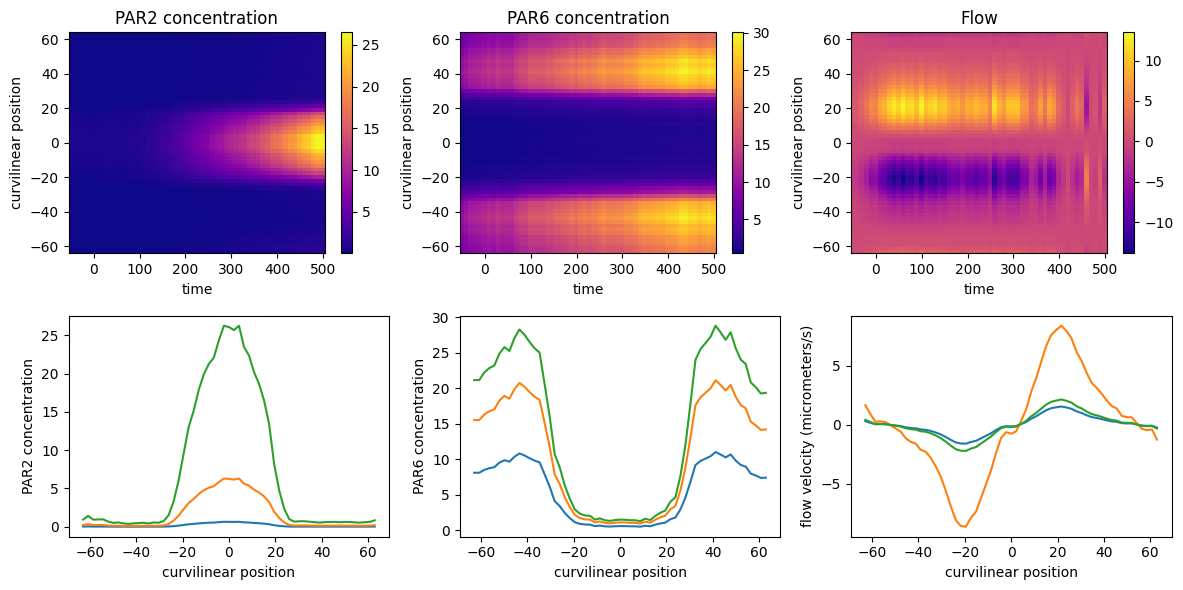

In [13]:
fig, ax = plt.subplots(figsize=(12,6), nrows = 2, ncols = 3)
ax = ax.flatten()

ax[0].set_title('PAR2 concentration')
c = ax[0].pcolor(T_PAR, X_PAR, rPAR2, cmap='plasma')
fig.colorbar(c, ax=ax[0])

ax[0].set_xlabel('time')
ax[0].set_ylabel('curvilinear position')

ax[1].set_title('PAR6 concentration')
c = ax[1].pcolor(T_PAR, X_PAR, rPAR6, cmap='plasma')
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('time')
ax[1].set_ylabel('curvilinear position')


ax[2].set_title('Flow')
c = ax[2].pcolor(T_PAR, X_PAR, rV, cmap='plasma')
fig.colorbar(c, ax=ax[2])
ax[2].set_xlabel('time')
ax[2].set_ylabel('curvilinear position')

tot = len(T_PAR)
for i in np.linspace(1, tot-1,3).astype(int):
    ax[3].plot(X_PAR, rPAR2[:,i])
ax[3].set_ylabel('PAR2 concentration')
ax[3].set_xlabel('curvilinear position')

tot = len(T_PAR)
for i in np.linspace(1, tot-1,3).astype(int):
    ax[4].plot(X_PAR, rPAR6[:,i])
ax[4].set_ylabel('PAR6 concentration')
ax[4].set_xlabel('curvilinear position')

tot = len(T_PAR)
for i in np.linspace(1, tot-1,3).astype(int):
    ax[5].plot(X_PAR, rV[:,i])
ax[5].set_ylabel('flow velocity (micrometers/s)')
ax[5].set_xlabel('curvilinear position')
plt.tight_layout()

In order to only fit the concentration fields, we built in a `nofit` flag in the `get_basis` function to explicitely remove any force function which would lie in the velocity dimension (the last dimension of the field $(P, A, v)$). We also need to modify the projection methods (the routine to compute the estimated diffusion as well as the force coefficients) so that we only compute quantities affecting the $P,A$ dimensions.

In [14]:
def compute_mean_diffusion(X, args):

    T, L = args
    dt = T/X.shape[0]
    dx = L/X.shape[2]
    N = X.shape[2:]
    volume_element = dx**len(N) / L**len(N)

    dX = (X[1:] - X[:-1])
    dX_flat = np.moveaxis(dX, 0, -1).reshape((dX.shape[1], -1))[0:2,:] # Slicing to only retain the concentration and not the v variable
    Dhat = dX_flat@dX_flat.T * volume_element/ (2*T)
    return Dhat


def infer_force_coefficients(X, args, basis_functions):

    T, L = args
    dt = T/X.shape[0]
    dX = (X[1:] - X[:-1]) / dt


    D_hat = compute_mean_diffusion(X, args)
    D_inv = np.linalg.inv(D_hat)

    B = evaluate_basis(X[:-1], basis_functions)

    Nt, nB, d, *N = B.shape
    dx = L / (N[0] - 1)
    volume_element = dx**len(N) / L**len(N)

    # Compute Gram matrix via einsum
    Bf = np.moveaxis(B, 0, 2).reshape((nB, d, -1))[:,0:2,:] # Slicing to only retain the concentration and not the v variable
    G = np.einsum('ab,ian,jbn->ij', D_inv, Bf, Bf, optimize=True) * dt * volume_element / T
    # Compute RHS
    dXf = np.moveaxis(dX, 0, 1).reshape((d, -1))[0:2,:] # Slicing to only retain the concentration and not the v variable
    b = np.einsum('ac,an,jcn->j', D_inv, dXf, Bf, optimize=True) * dt * volume_element / T

    Fhat = np.linalg.solve(G, b)
    return Fhat

def reconstruct_force_field(X, coeffs, basis_functions):

    X = np.moveaxis(X, 0, 1)
    F = np.zeros_like(X)
    for c, f in zip(coeffs, basis_functions.values()):
        F += c * f(X)
    F = np.moveaxis(F, 1, 0)
    return F

def compute_scores(X, args, coeffs, basis_functions, n0, p=0.001):

    T, L = args
    dt = T/X.shape[0]
    dX = np.diff(X, axis=0)
    F = reconstruct_force_field(X[:-1], coeffs, basis_functions)
    residual = dX / dt - F

    D_hat = compute_mean_diffusion(X, args)
    D_inv = np.linalg.inv(D_hat)

    dx = L / (X.shape[2] - 1)
    spatial_dims = X.shape[2:]
    vol = dx ** len(spatial_dims)
    d = dX.shape[1]

    residual_flat = np.moveaxis(residual, 0, -1).reshape(d, -1)[0:2,:] # Slicing to only retain the concentration and not the v variable
    dX_flat = np.moveaxis(dX, 0, -1).reshape(d, -1)[0:2,:] # Slicing to only retain the concentration and not the v variable

    residual_sq = np.einsum('ab,aN,bN->', D_inv, residual_flat, residual_flat, optimize=True)

    LL = -0.25 * residual_sq * dt * vol
    nB = len(coeffs)

    AIC = LL - nB
    PASTIS = LL - nB * np.log(n0 / p)

    return PASTIS, AIC

In [15]:
basis = get_basis(field_dim=3, dx=dx, n=1, degree=3, nofit=[2])
sfi_engine = (infer_force_coefficients, compute_scores, compute_mean_diffusion)
fbasis, fcoeffs, _  = greedy_basis_search(X, (T, L), basis, sfi_engine, method='PASTIS', p = 0.001, max_moves=200, ntrials = None)

Trial 60/60:  18%|█▊        | 35/200 [00:01<00:08, 19.95it/s]


In [16]:
from IPython.display import Math
Math(get_latex_model(fbasis, fcoeffs, scale_factors=None))

<IPython.core.display.Math object>

In [17]:
Math('$$\\frac{\\partial u_{0}}{\\partial t} &= -1.7\\times 10^{-4}u_{0}^{2} u_{1}^{1} +0.00889u_{0}^{1} \\notag \\\\\n\\frac{\\partial u_{1}}{\\partial t} &= -1.0\\times 10^{-4}u_{0}^{1} u_{1}^{2} +0.00429u_{1}^{1} -1.1\\times 10^{-4}u_{1}^{2} -3.2\\times 10^{-5}u_{1}^{1} u_{2}^{2} \\notag\n$$')

<IPython.core.display.Math object>

## 5. Going beyond
You can now try a number of other things, either to improve the method or to simply change the model selection approach

1. Improve the robustness of the estimators to large $\Delta t$ following the appendix of the PASTIS paper
2. We can try to implement LASSO regression to infer the force field

The alternative 1. has never been tried on this dataset, so pushing the PASTIS approach is to see if it can infer the underlying model is very interesting. The alternative 2., although interesting and widely applied to regression problem, is known to fail with this data. We illustrate how to implement it below.

In [18]:
from sklearn.linear_model import lasso_path

def compute_G_b(X, args, basis_functions):

    T, L = args
    dt = T/X.shape[0]
    dX = (X[1:] - X[:-1]) / dt

    D_hat = compute_mean_diffusion(X, args)
    # The diffusion is small, to bound the lasso path values we scale D by its max value.
    D_inv = np.linalg.inv(D_hat/D_hat.max())

    B = evaluate_basis(X[:-1], basis_functions)

    Nt, nB, d, *N = B.shape
    dx = L / (N[0] - 1)
    volume_element = dx**len(N) / L**len(N)

    # Select only the
    Bf = np.moveaxis(B, 0, 2).reshape((nB, d, -1))[:,0:2,:]

    G = np.einsum('ab,ian,jbn->ij', D_inv, Bf, Bf, optimize=True) * dt * volume_element / T
    # Compute RHS
    dXf = np.moveaxis(dX, 0, 1).reshape((d, -1))[0:2,:]
    b = np.einsum('ac,an,jcn->j', D_inv, dXf, Bf, optimize=True) * dt * volume_element / T
    return G, b

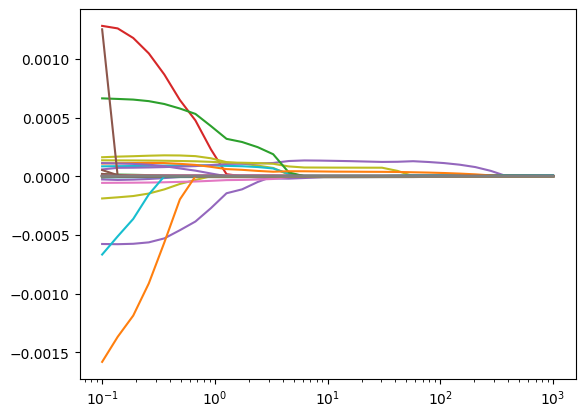

In [19]:
G, b = compute_G_b(X, (T, L), basis)
alphas, coeffs, _ = lasso_path(G, b, alphas=np.logspace(-1, 3, 30), max_iter=1e8)

plt.figure()
for coeff in coeffs:
    plt.plot(alphas, coeff)
plt.xscale('log')

plt.show()

In [20]:
where = np.where(coeffs[:,5] != 0)[0]
fbasis_keys = np.array(list(basis.keys()))[where]
fbasis_f = np.array(list(basis.values()))[where]

fbasis = {}
for key, val in zip(fbasis_keys, fbasis_f):
    fbasis[key] = val

In [21]:
from IPython.display import Math
Math(get_latex_model(fbasis, coeffs[where,0], scale_factors=None))

<IPython.core.display.Math object>